In [39]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
plt.style.use('ggplot')
import seaborn as sns


In [40]:
df = pd.read_csv('data/data.csv') # loading the data
print(df.head(20)) # displaying the first 20 rows of the data
print(df.columns.tolist()) # displaying the columns of the data

    ID  Square_Feet  Num_Bedrooms  Num_Bathrooms  Num_Floors  Year_Built  \
0    1   143.635030           1.0            3.0         3.0      1967.0   
1    2   287.678577           1.0            2.0         1.0      1949.0   
2    3   232.998485           1.0            3.0         2.0      1923.0   
3    4   199.664621           5.0            2.0         2.0      1918.0   
4    5    89.004660           4.0            3.0         3.0      1999.0   
5    6    88.998630           5.0            3.0         2.0      1959.0   
6    7    64.520903           4.0            3.0         1.0      1938.0   
7    8   266.544036           5.0            1.0         3.0      1973.0   
8    9   200.278753           5.0            1.0         1.0      1988.0   
9   10   227.018144           3.0            2.0         1.0      1917.0   
10  11    55.146124           5.0            2.0         2.0      1918.0   
11  12   292.477463           2.0            1.0         3.0      1935.0   
12  13   258

In [41]:
print("Missing Values:\n", df.isnull().sum())  # check for missing values
print("\nDuplicated Values:\n", df.duplicated().sum()) # and duplicates

Missing Values:
 ID                    0
Square_Feet           5
Num_Bedrooms          6
Num_Bathrooms         1
Num_Floors            3
Year_Built            2
Has_Garden            6
Has_Pool              1
Garage_Size           4
Location_Score        1
Distance_to_Center    1
Price                 0
dtype: int64

Duplicated Values:
 0


1. Clearly we have some null values so lets fill them with mean values of their respective columns.
2. No duplicate values so we are good to go after just dealing with the null rows.

In [42]:
# filling missing values with the mean of the column
df.fillna(df.mean(), inplace=True)
df.isnull().sum()  # check if missing values have been filled

ID                    0
Square_Feet           0
Num_Bedrooms          0
Num_Bathrooms         0
Num_Floors            0
Year_Built            0
Has_Garden            0
Has_Pool              0
Garage_Size           0
Location_Score        0
Distance_to_Center    0
Price                 0
dtype: int64

Filled them! let us make sure that the columns are of right datatypes as seen by pandas

In [43]:
# check data types
print("\nData Types:\n", df.dtypes)


Data Types:
 ID                      int64
Square_Feet           float64
Num_Bedrooms          float64
Num_Bathrooms         float64
Num_Floors            float64
Year_Built            float64
Has_Garden            float64
Has_Pool              float64
Garage_Size           float64
Location_Score        float64
Distance_to_Center    float64
Price                   int64
dtype: object


LGTM!
Let us remove the ID column so as to prevent unnecessary data to processed and plotted.

In [44]:
if 'ID' in df.columns:
	df.drop(['ID'], axis=1, inplace=True)
print(df.columns.tolist())

['Square_Feet', 'Num_Bedrooms', 'Num_Bathrooms', 'Num_Floors', 'Year_Built', 'Has_Garden', 'Has_Pool', 'Garage_Size', 'Location_Score', 'Distance_to_Center', 'Price']


Dropped ID!

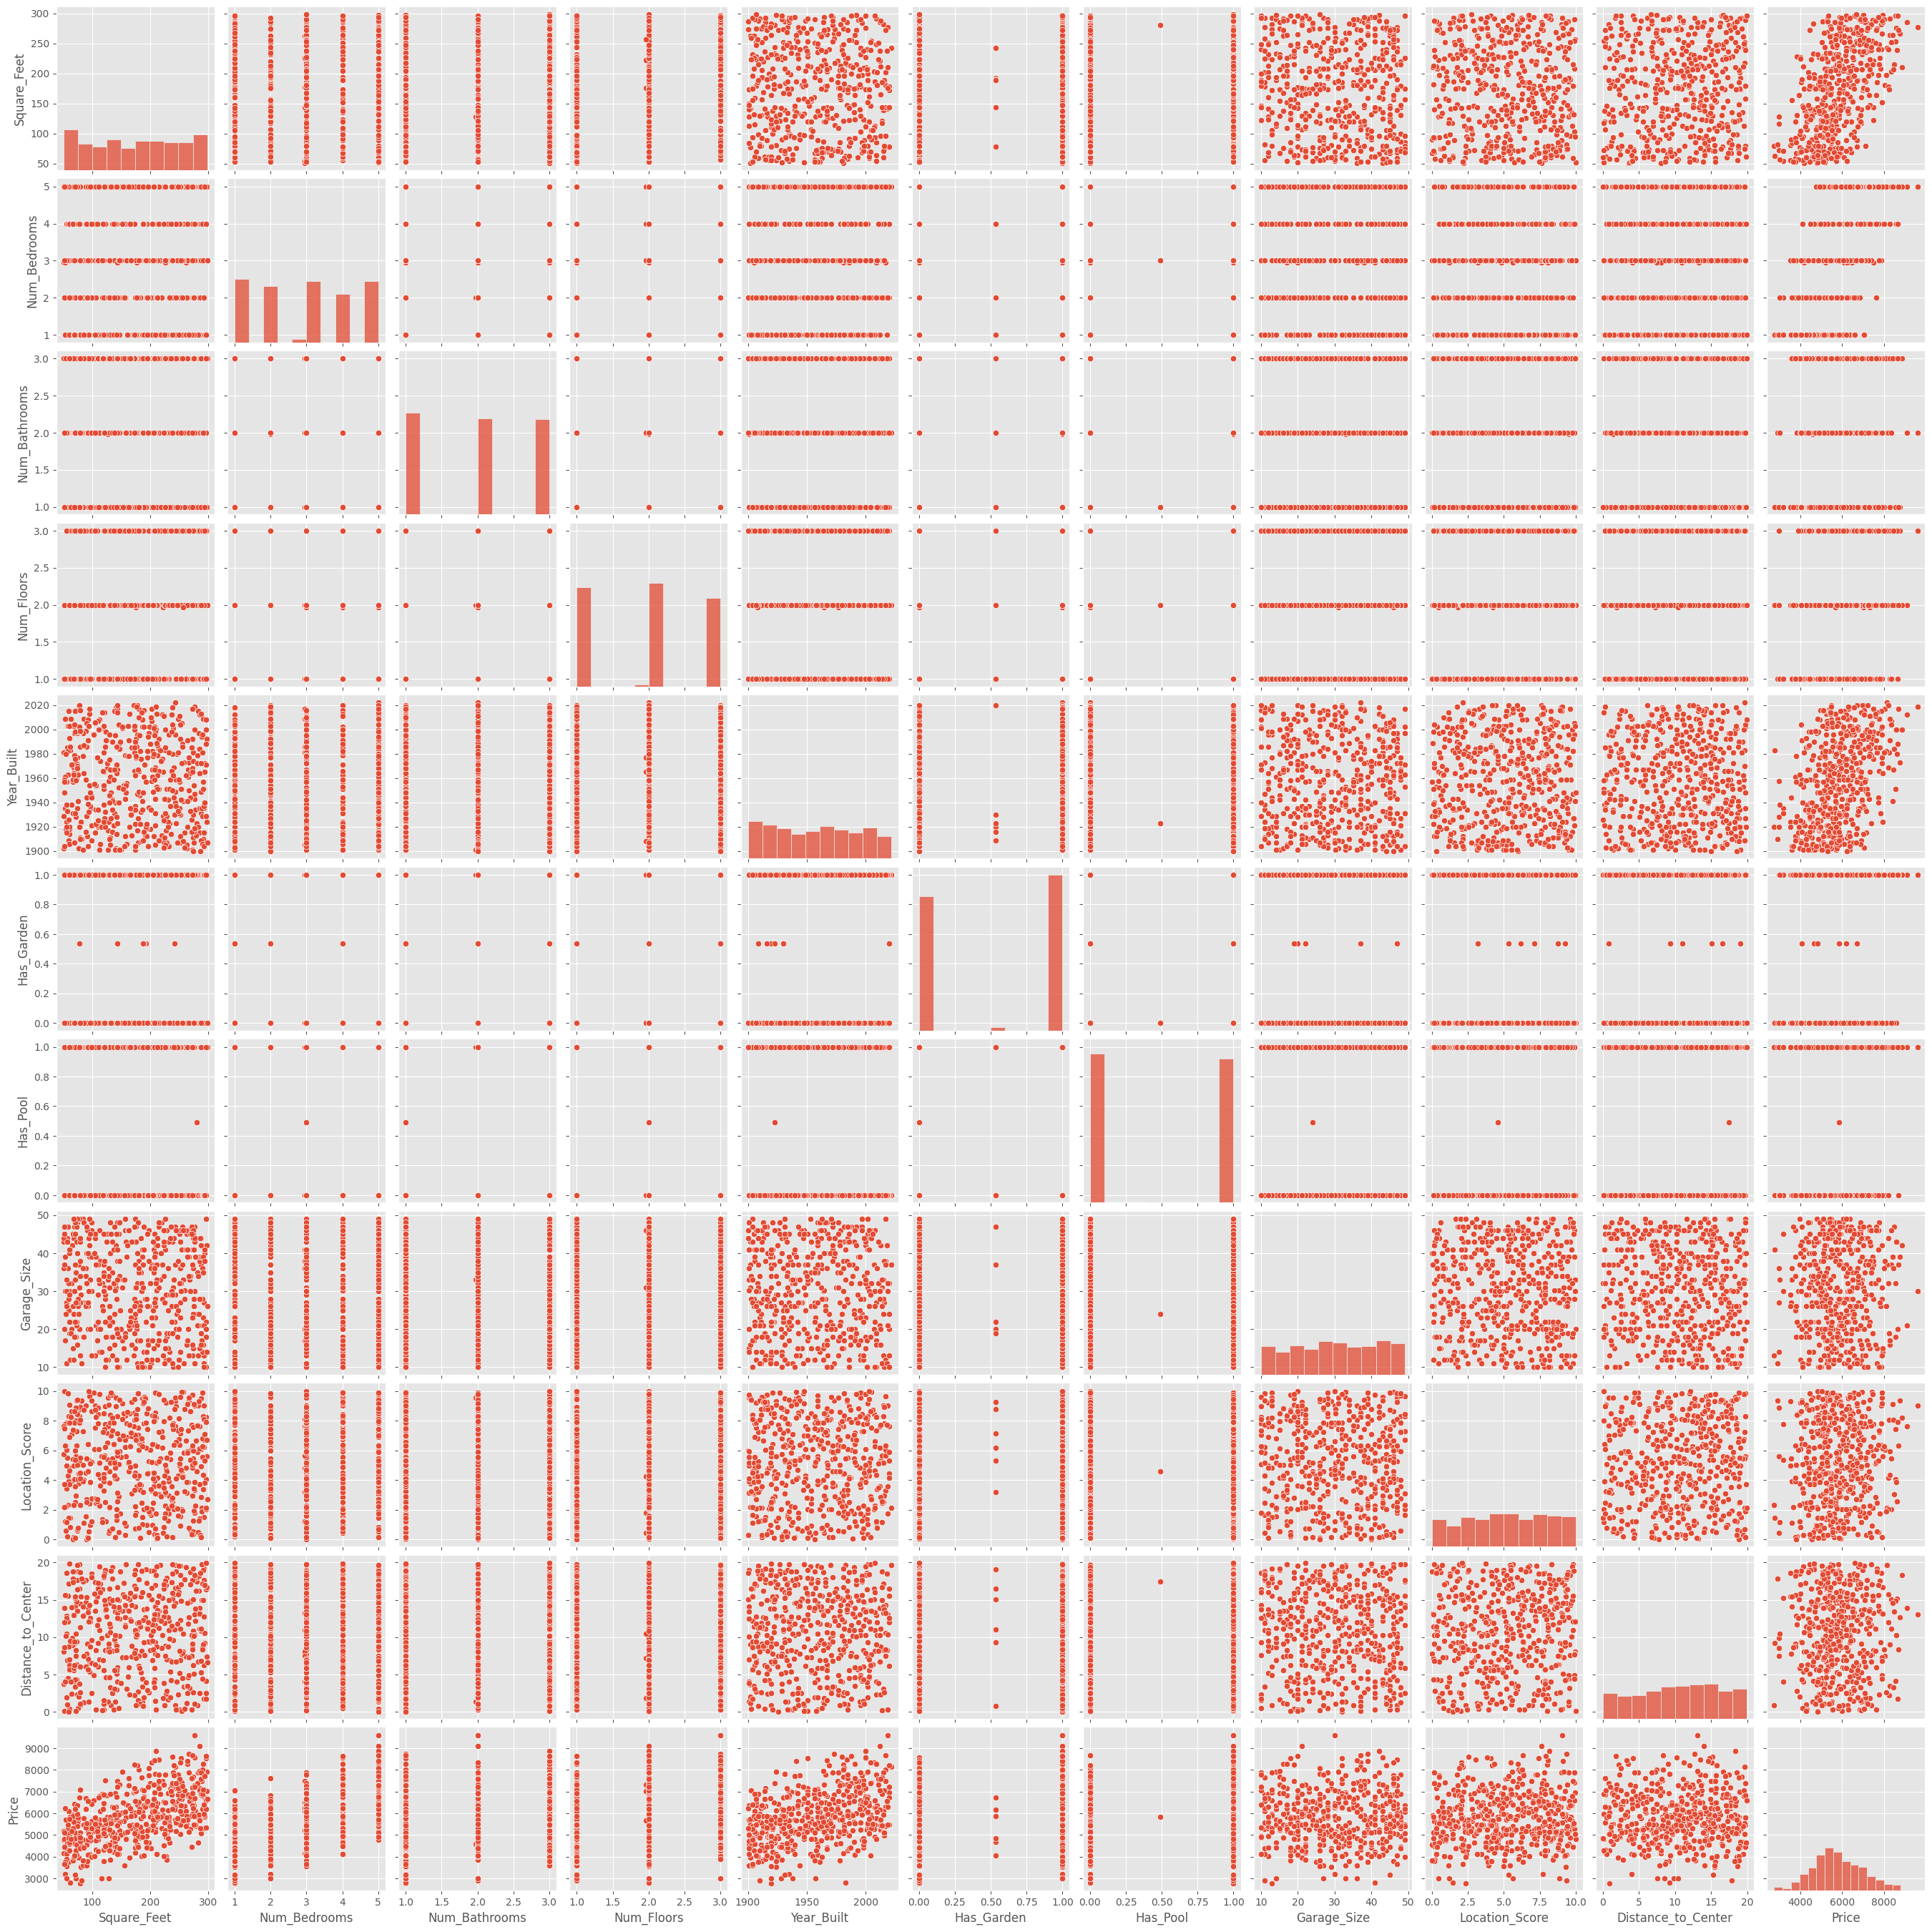

In [45]:
# plotting some graphs between all the columns pairwise
sns.pairplot(df)
plt.show()

In [46]:
# Now lets calculate the correlation matrix, print it in a sorted manner based on its correlation with price
correlation_matrix = df.corr()
print(correlation_matrix['Price'].sort_values(ascending=False))


Price                 1.000000
Num_Bedrooms          0.559894
Square_Feet           0.557757
Year_Built            0.411751
Num_Floors            0.177201
Num_Bathrooms         0.154483
Has_Pool              0.136693
Has_Garden            0.111362
Location_Score        0.074561
Garage_Size           0.026694
Distance_to_Center    0.001801
Name: Price, dtype: float64


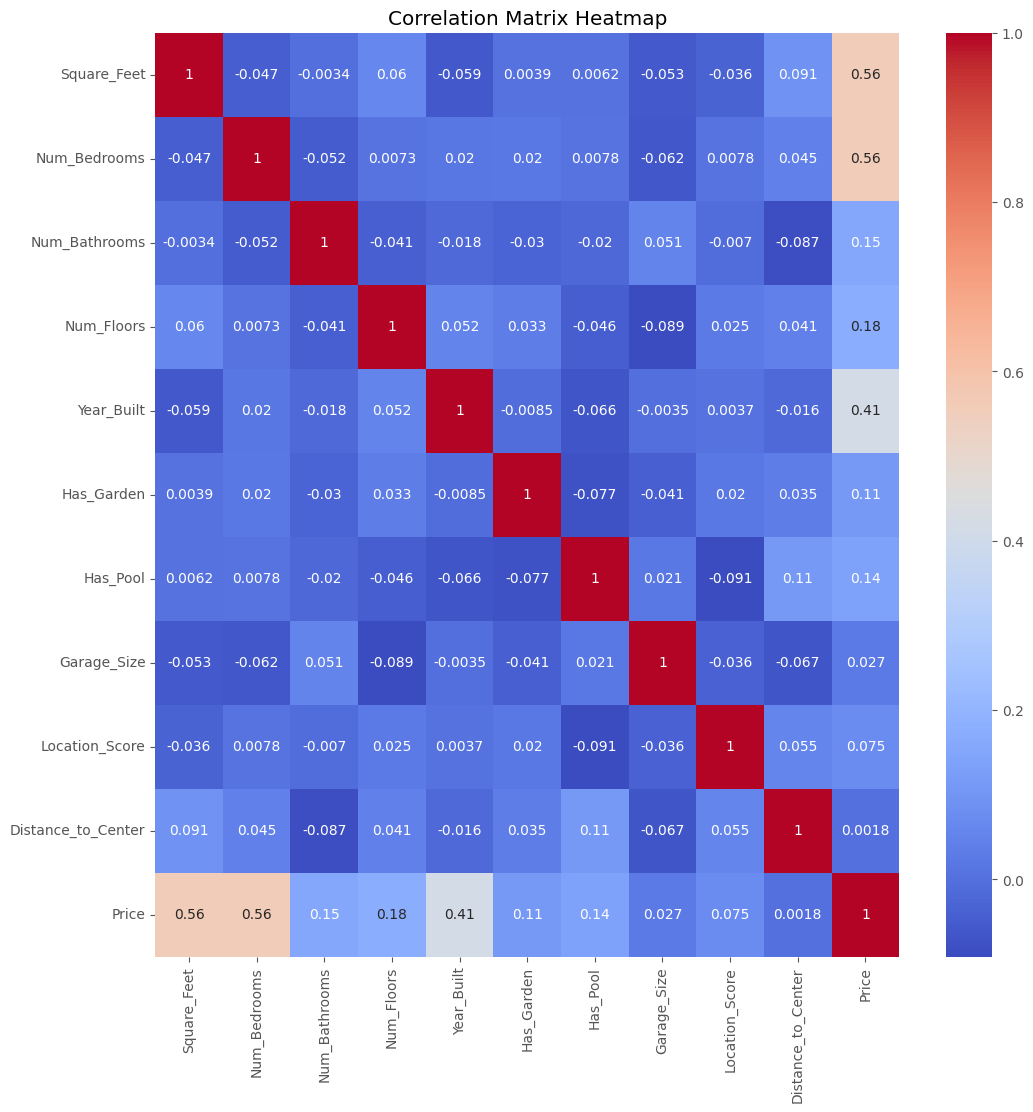

In [47]:
# plotting the correlation matrix
plt.figure(figsize=(12, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

We have sufficiently analysed our data and its time to shuffle and split the data in 80:20 ratio where 80% of the data would be used to train our model and 20% of the data would be used to test our model on.

In [48]:
df = df.sample(frac=1).reset_index(drop=True)  # shuffling the data
train_df = df[0:df.shape[0]*80//100]  # 80% of the data for training
test_df = df[df.shape[0]*80//100:]  # 20% of the data for testing
print(train_df.shape, test_df.shape)


(400, 11) (100, 11)


In [49]:
#Let us begin with creating the Feature Matrix and the Target Vector
X_train = train_df.drop(['Price'], axis=1).values # Feature Matrix of independent variables
y_train = train_df['Price'].values # Target Vector of dependent variable (Price)

X_test = test_df.drop(['Price'], axis=1).values # Similarly for the test data
y_test = test_df['Price'].values

In [50]:
# Add intercept column to the Feature Matrix
X_train = np.c_[np.ones(X_train.shape[0]), X_train] # adding a column of ones to the feature matrix
X_test = np.c_[np.ones(X_test.shape[0]), X_test] # similarly for the test data
X_train.shape, X_test.shape

((400, 11), (100, 11))

Succesfully Added the intercept column!

In [52]:
# # Function for calculating the Ordinary Least Squares (OLS)
def ols_calculator(X, y):
    # OLS formula: W = (X^T X)^(-1) X^T y as learnt from https://colab.research.google.com/drive/12Ey1IzHPWGLfm9u_g7mSKKOwM1p9WHsS?usp=sharing
    X_transpose = X.T
    W_ols = np.linalg.inv(X_transpose @ X) @ X_transpose @ y
    return W_ols

# Function for Maximum Likelihood Estimation (MLE)
def mle_calculator(X, y):
    # MLE gives the same weights as OLS for linear regression
    W_mle = ols_calculator(X, y)  # Reuse the OLS function for simplicity
    # Estimate sigma^2
    residuals = y - X @ W_mle
    sigma2 = np.mean(residuals**2)
    return W_mle, sigma2

# Compute the OLS values
W_ols = ols_calculator(X_train, y_train)
W_mle, sigma2_mle = mle_calculator(X_train, y_train)

# Predictions using the weights
y_pred_ols = X_train @ W_ols
y_pred_mle = X_train @ W_mle

# Print the calculated metrics
print("OLS Weights (W):", W_ols)
print("MLE Weights (W):", W_mle)
print("MLE Estimated Variance (σ^2):", sigma2_mle)
print("Predictions (OLS):", y_pred_ols)
print("Predictions (MLE):", y_pred_mle)

OLS Weights (W): [-2.95412138e+04  1.01117832e+01  5.06885324e+02  2.85158573e+02
  2.04708922e+02  1.55074984e+01  3.08309080e+02  4.80257492e+02
  1.11123151e+01  4.81555174e+01 -2.00794384e+01]
MLE Weights (W): [-2.95412138e+04  1.01117832e+01  5.06885324e+02  2.85158573e+02
  2.04708922e+02  1.55074984e+01  3.08309080e+02  4.80257492e+02
  1.11123151e+01  4.81555174e+01 -2.00794384e+01]
MLE Estimated Variance (σ^2): 49924.379168505846
Predictions (OLS): [5572.54063869 4697.54843287 6688.79956641 8281.80961692 5055.80431958
 6148.70705218 6804.91200502 5903.4157761  7194.52189996 5906.22739391
 5574.47069508 9162.92664453 4823.61547733 7378.56822243 4471.4662787
 7538.05892515 5853.39257601 4716.95295068 6042.87444552 5191.63119339
 5733.67888022 4463.22769943 5130.68313669 4869.14132159 6035.84249688
 5657.46758286 6847.18332904 3559.30944071 7094.38352084 6991.97381746
 6710.48418551 5708.18244166 8212.68251373 6725.01193926 7274.88509247
 4611.3006508  6049.25626884 5254.16753668

Computing and Evaluating the model based on our trained data

In [ ]:
# Define the evaluation function
def evaluate_model(y_true, y_pred):
    rss = np.sum((y_true - y_pred) ** 2)  # Residual Sum of Squares
    mae = np.mean(np.abs(y_true - y_pred))  # Mean Absolute Error
    mse = np.mean((y_true - y_pred) ** 2)  # Mean Squared Error
    rmse = np.sqrt(mse)                    # Root Mean Squared Error
    r2 = 1 - (rss / np.sum((y_true - np.mean(y_true)) ** 2))  # R^2
    return {"RSS": rss, "MAE": mae, "MSE": mse, "RMSE": rmse, "R^2": r2}

# Compute the predictions for the train data
y_train_pred = X_train @ W_ols
y2_train_pred = X_train @ W_mle

# Evaluate the model on the train data

train_metrics = evaluate_model(y_train, y_train_pred)
train2_metrics = evaluate_model(y_train, y2_train_pred)
#print the metrics
print("Train Set Metrics (OLS):", train_metrics)
print("Train Set Metrics (MLE):", train2_metrics)
print("OLS Weights (W):", W_ols)
print("MLE Weights (W):", W_mle)
print("Predictions on the Train Set (OLS):", y_train_pred)

Now lets begin the testing with the new found weights!

In [54]:
# Compute the predictions for the test data
y_pred_ols_test = X_test @ W_ols
y_pred_mle_test = X_test @ W_mle

#evaluating the model
test_metrics = evaluate_model(y_train, y_train_pred)
test2_metrics = evaluate_model(y_train, y2_train_pred)

#print the metrics
print("Test Set Metrics (OLS):", test_metrics)
print("Test Set Metrics (MLE):", test2_metrics)
print("OLS Weights (W):", W_ols)
print("MLE Weights (W):", W_mle)
print("Predictions on the Test Set (OLS):", y_pred_ols_test)

Test Set Metrics (OLS): {'RSS': np.float64(19969751.66740234), 'MAE': np.float64(168.66238940848262), 'MSE': np.float64(49924.379168505846), 'RMSE': np.float64(223.43764044696195), 'R^2': np.float64(0.9660600940573044)}
Test Set Metrics (MLE): {'RSS': np.float64(19969751.66740234), 'MAE': np.float64(168.66238940848262), 'MSE': np.float64(49924.379168505846), 'RMSE': np.float64(223.43764044696195), 'R^2': np.float64(0.9660600940573044)}
OLS Weights (W): [-2.95412138e+04  1.01117832e+01  5.06885324e+02  2.85158573e+02
  2.04708922e+02  1.55074984e+01  3.08309080e+02  4.80257492e+02
  1.11123151e+01  4.81555174e+01 -2.00794384e+01]
MLE Weights (W): [-2.95412138e+04  1.01117832e+01  5.06885324e+02  2.85158573e+02
  2.04708922e+02  1.55074984e+01  3.08309080e+02  4.80257492e+02
  1.11123151e+01  4.81555174e+01 -2.00794384e+01]
Predictions on the Test Set (OLS): [5787.86109763 5612.49772259 4648.08059377 6358.39998785 6473.3078077
 6571.61082475 6645.04473788 4246.39641636 6993.01207303 4872

FINALLY
we will now plot the scatter between actual and predicted and then finally also checkout the residual distribution plot!

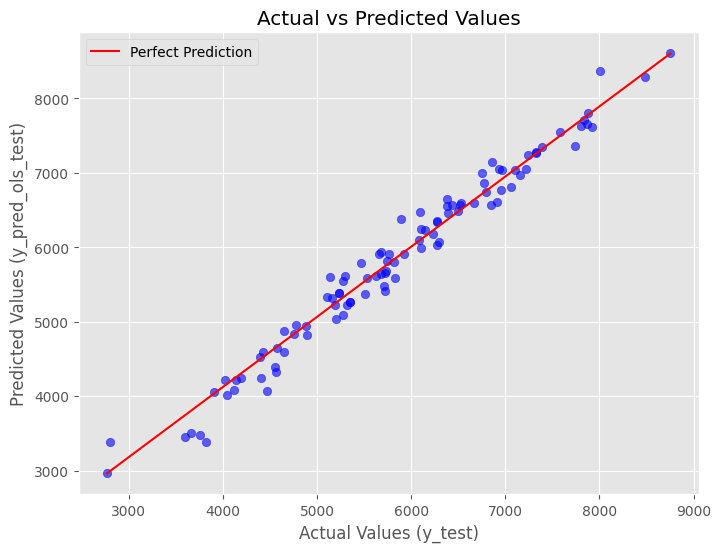

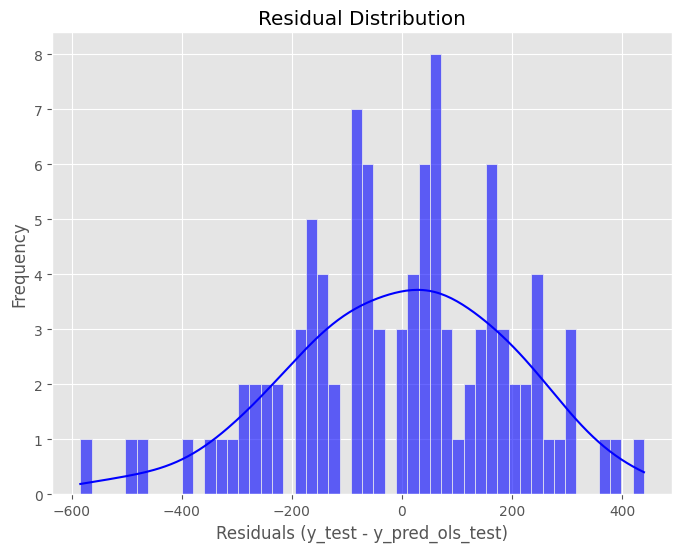

In [55]:
# Scatter plot: Actual vs. Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_ols_test, color="blue", alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_pred_ols_test.min(), y_pred_ols_test.max()], color="red", linestyle="-", label="Perfect Prediction")
plt.title("Actual vs Predicted Values")
plt.xlabel("Actual Values (y_test)")
plt.ylabel("Predicted Values (y_pred_ols_test)")
plt.legend()
plt.grid(True)
plt.show()

# Residual distribution plot
residuals = y_test - y_pred_ols_test  # Calculate residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=50, kde=True, color="blue", alpha=0.6)
plt.title("Residual Distribution")
plt.xlabel("Residuals (y_test - y_pred_ols_test)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


The Graphs signifies that our model made decent predictions on the test data from the train data! (HIGH INTERSECTIONS BETWEEN THE PLOTS AND THE PERFECT PREDICTION'S RED LINE)

Thank You!

Author: Aayushman Kumar
Roll: 230029